In [1]:
import pandas as pd
import numpy as np
import scipy as sci
import arch
import pyvinecopulib as pv
import matplotlib.pyplot as plt
import plotly.express as px
from SourceCodes.invariance_analysis import quick_invariance_analysis
from SourceCodes.garch_aux_methods import zero_mean_garch_1_1_scenario


columns_mappings = {'ES1 Index': 'SP500',
                    'NQ1 Index': 'Nasdaq100',
                    'VG1 Index': 'Euro Stox50',
                    'BZ1 Index': 'Ibovespa',
                    'TY1 Comdty':'10-Year Treasury',
                    'RX1 Comdty': 'Euro Bund',
                    'EC1 Curncy': 'EUR/USD',
                    'BP1 Curncy': 'GBP/USD',
                    'UC1 Curncy': 'USD/BRL',
                    'CL1 Comdty': 'WTI',
                    'CO1 Comdty': 'Brent'}

selected_securities = ['SP500', 'Nasdaq100', 'Ibovespa', '10-Year Treasury','USD/BRL']


In [2]:
# Reading data
df = pd.read_csv("Data/data.csv", index_col="Dates", date_parser = pd.to_datetime).rename(columns=columns_mappings)[selected_securities]
df.sort_index(inplace=True)
returns_scale_factor = 100
df_log_ret = np.log(df).diff() * returns_scale_factor
n = df.shape[0]
n_os = 252
n_scenarios = 3000
seeds = [int(x) for x in np.ones(len(selected_securities)).tolist()]

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


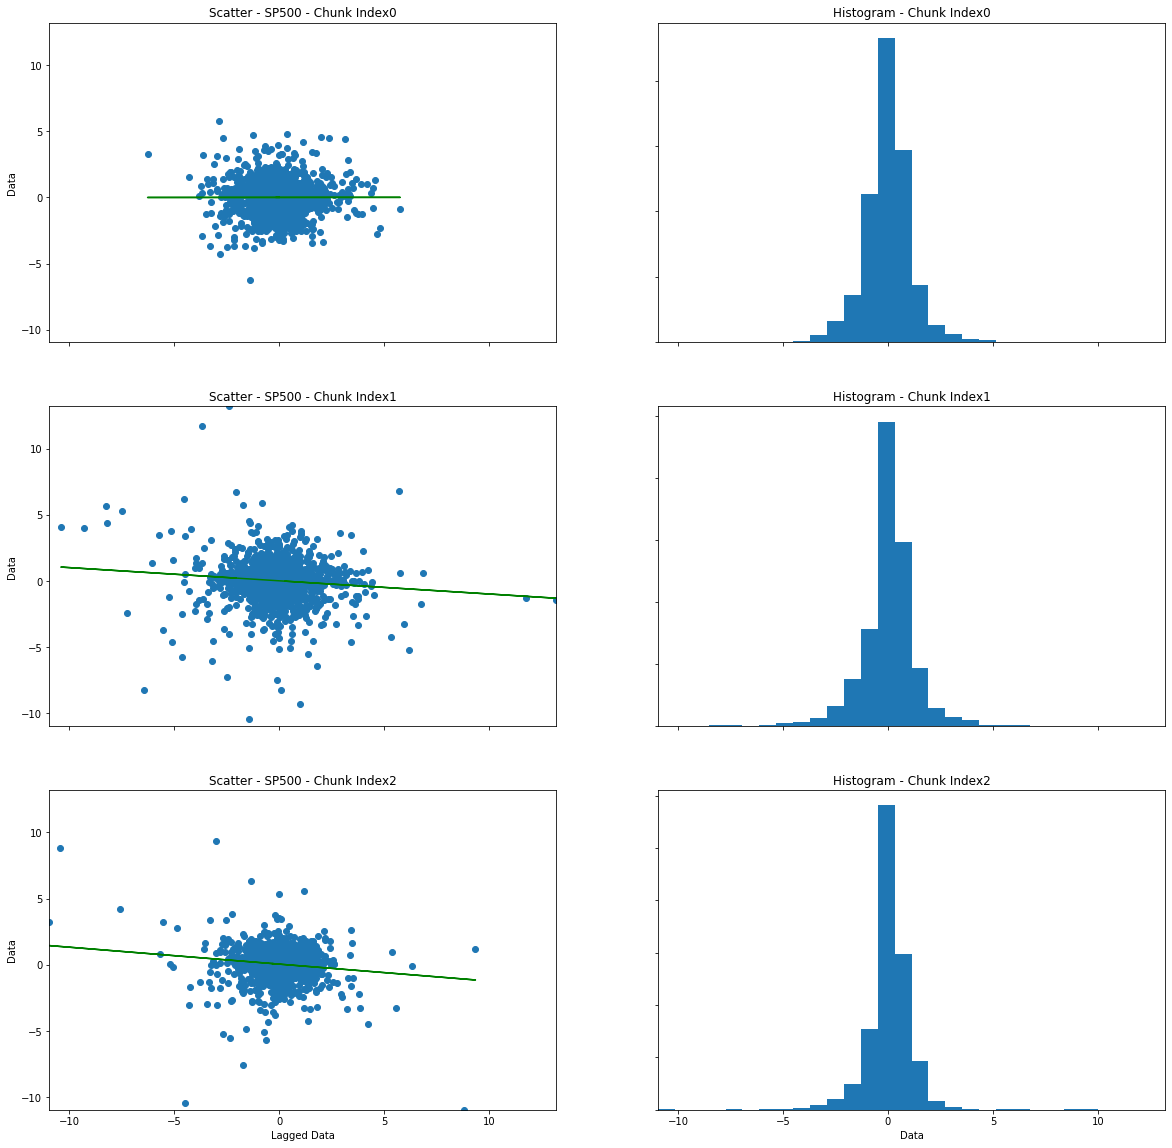

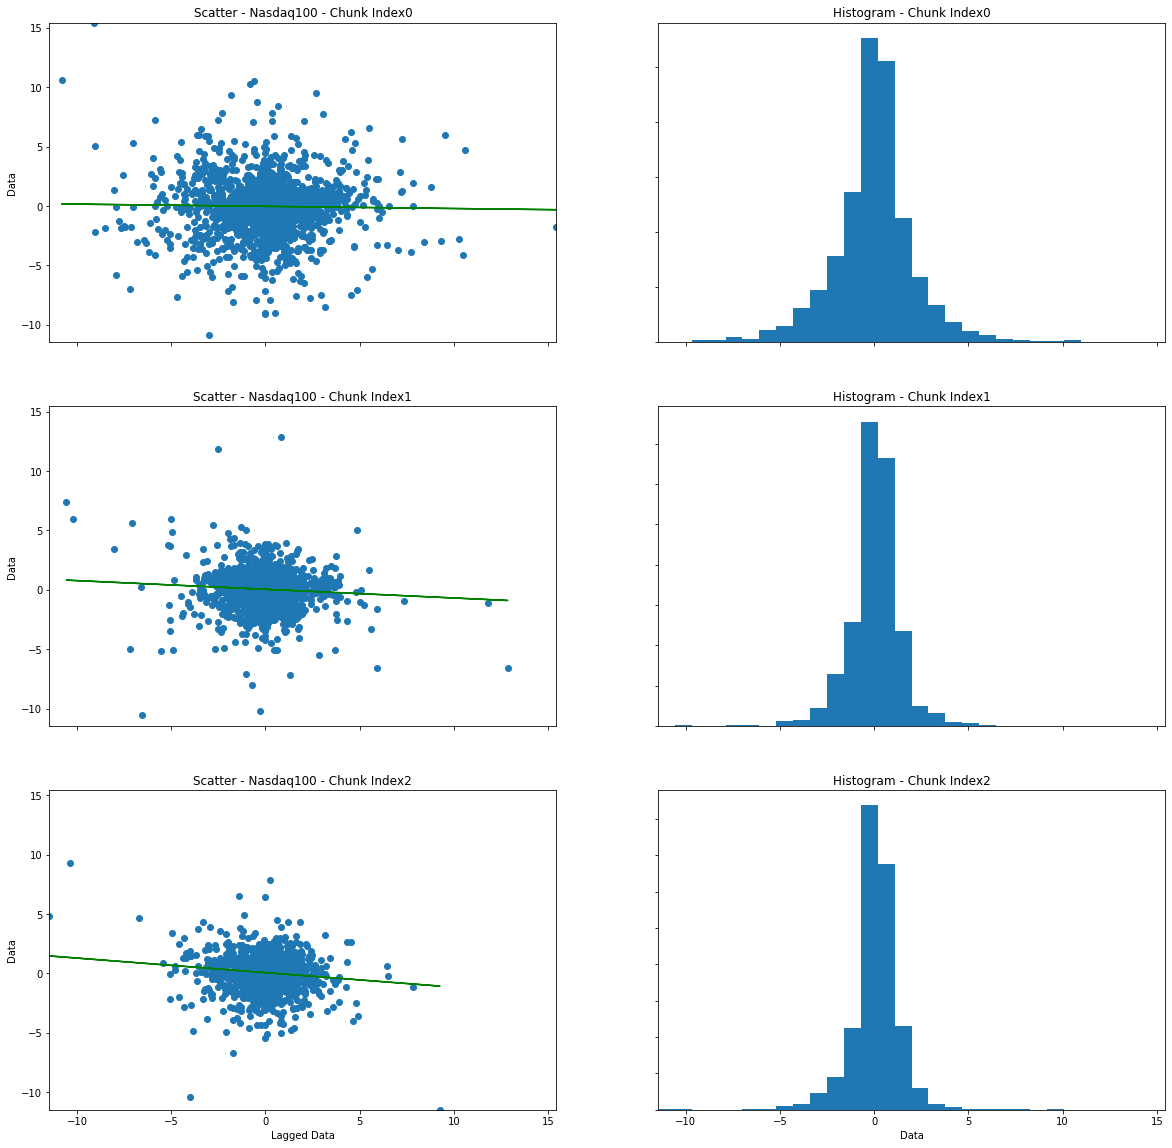

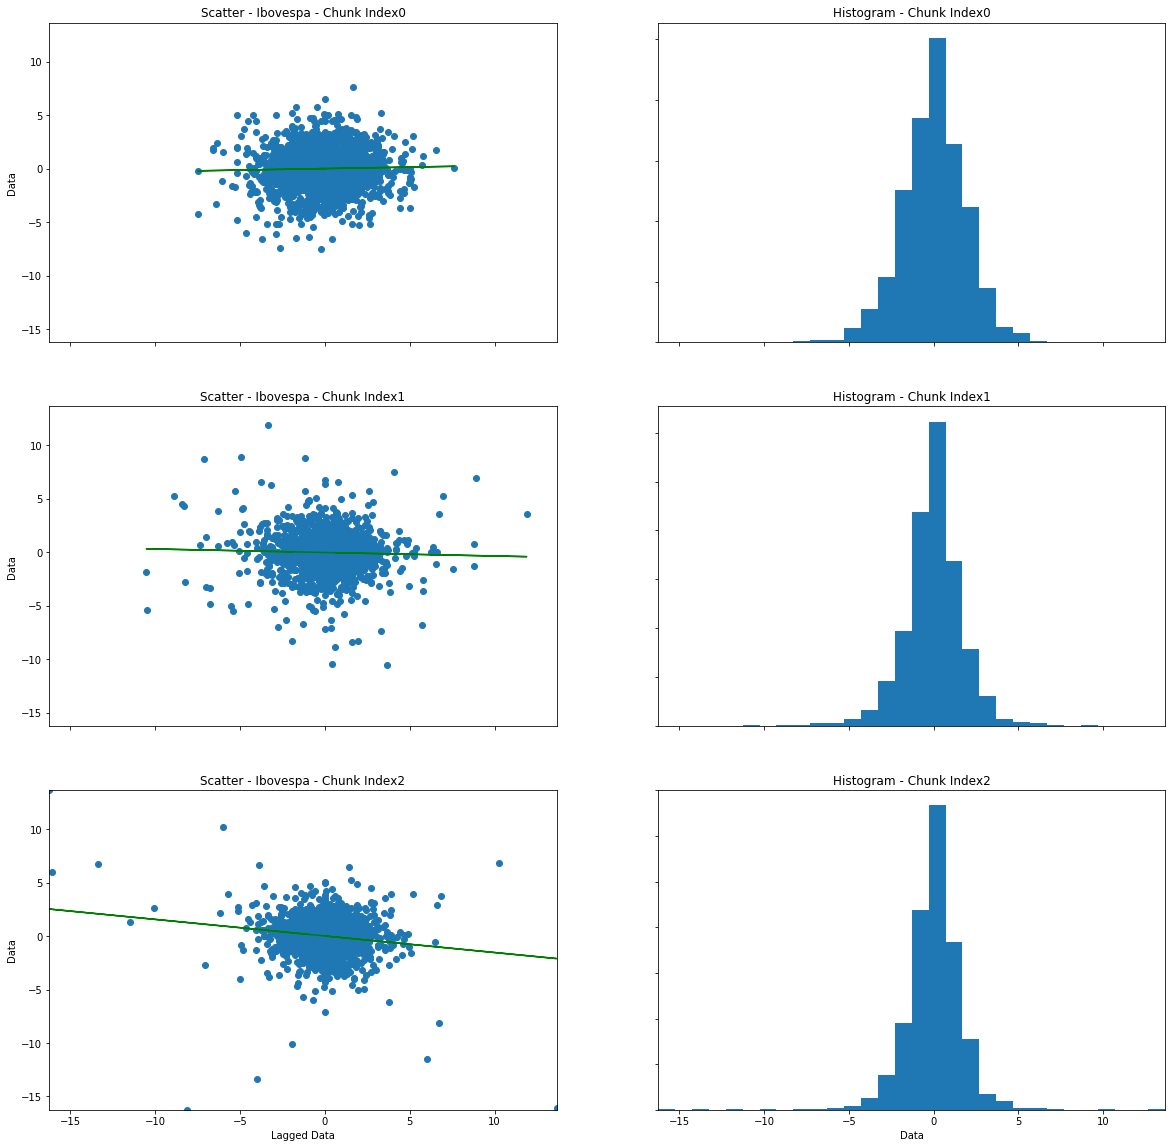

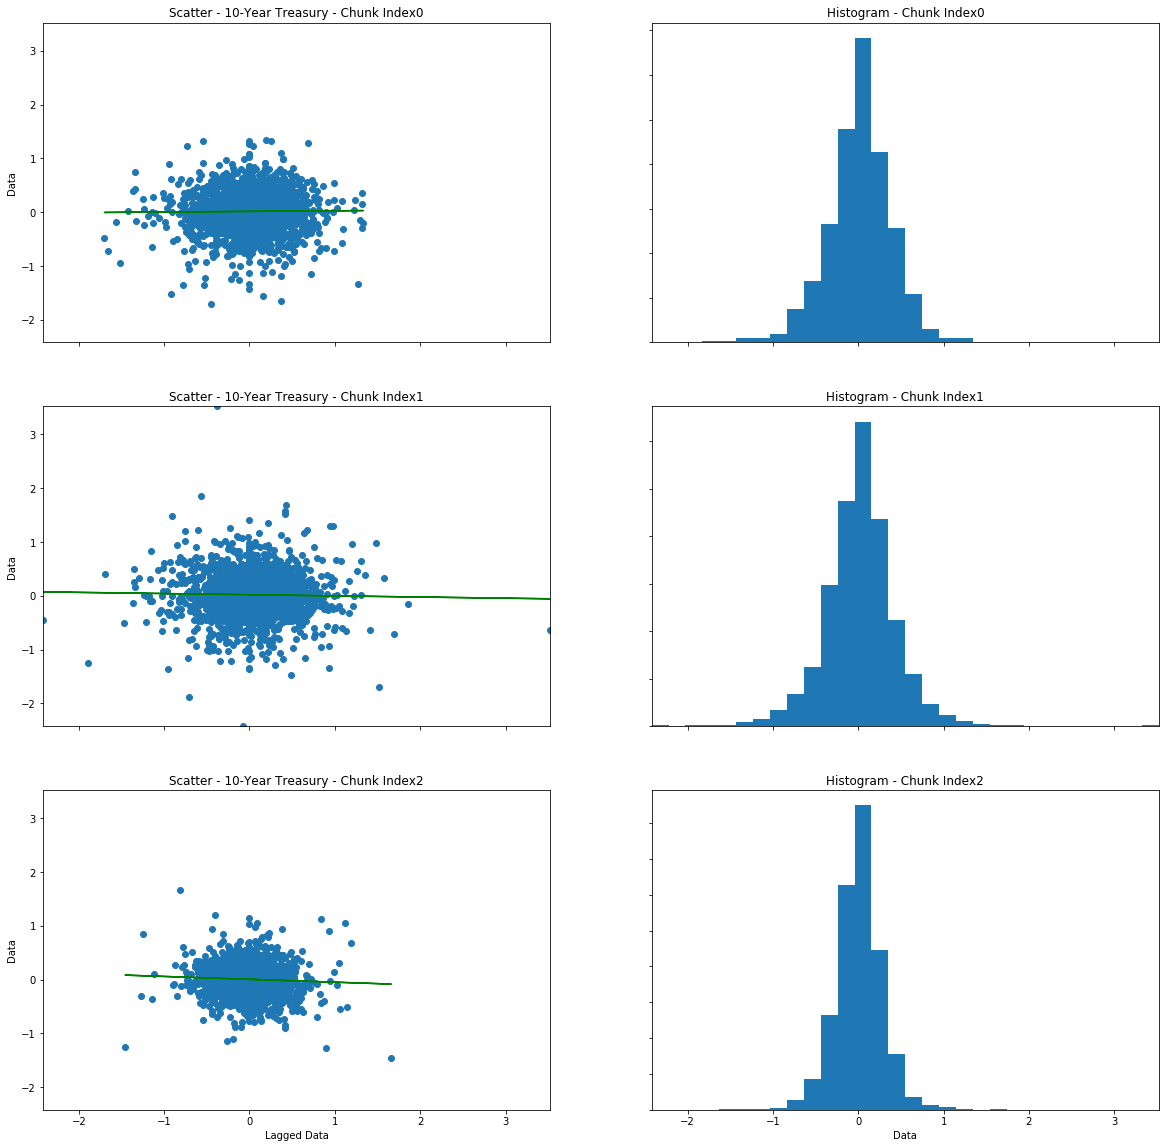

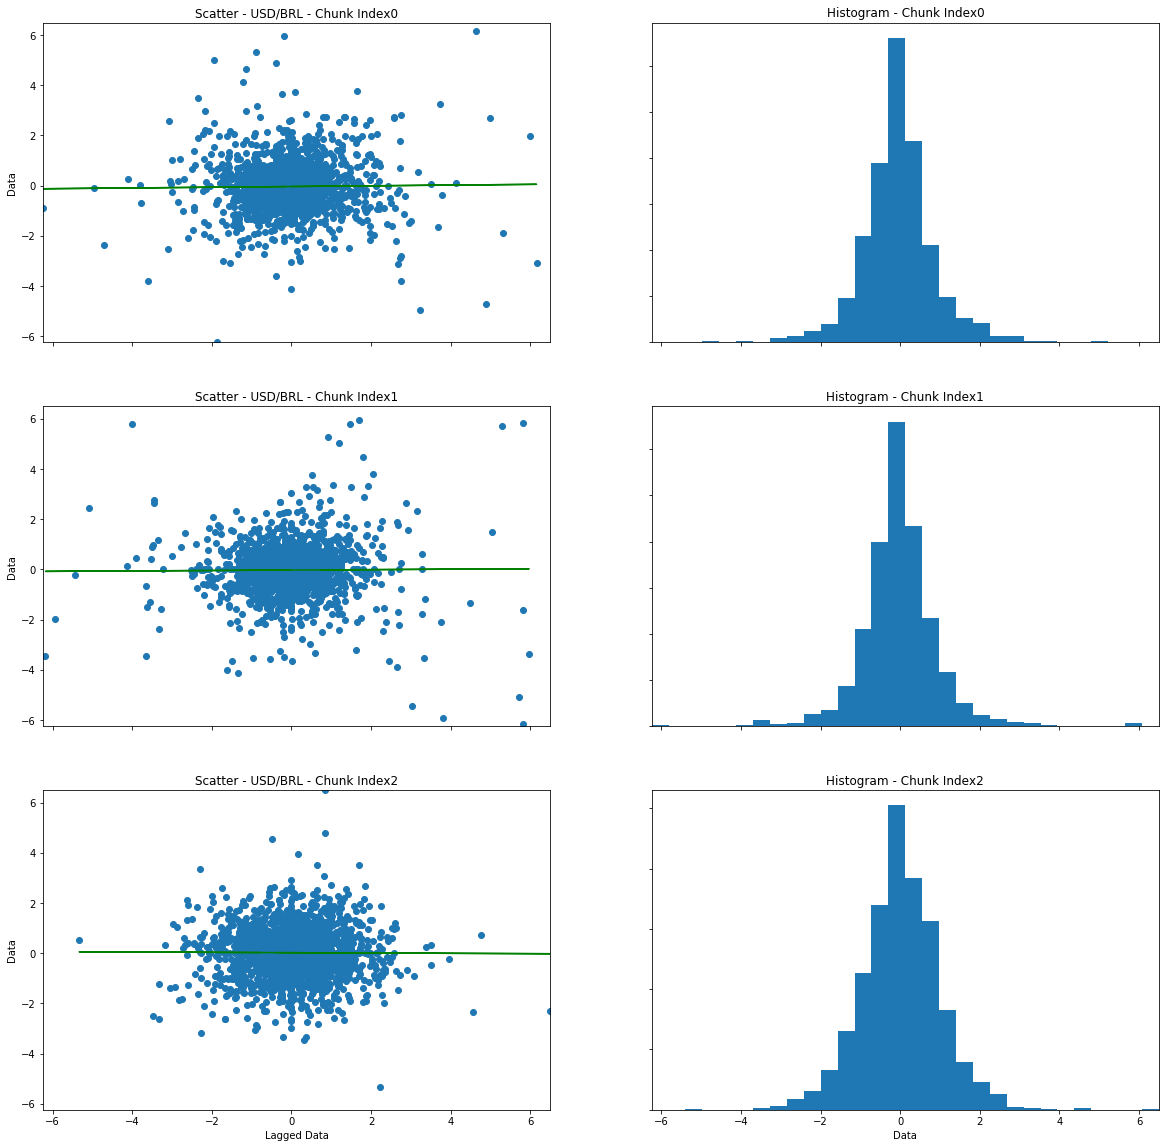

In [3]:
# Quick Invariance Analysis
for item in df_log_ret.columns:
    fig, axs = quick_invariance_analysis(df_log_ret[item].iloc[:-n_os], n_chunks=3, nbins=30)
    fig.set_size_inches(20, 20)

In [4]:
# Fitting a GARCH(1,1) Model and
model_list = []

for k, item in enumerate(df_log_ret):
    mdl = list()
    mdl.append(arch.arch_model(df_log_ret.iloc[1:-n_os, k] , mean="Zero", vol="GARCH", p=1, q=1, dist="normal"))
    mdl[0].constraints()
    mdl.append(mdl[0].fit())
    model_list.append(mdl)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 453823387.4988096
Iteration:      2,   Func. Count:     11,   Neg. LLF: 11357.310371514155
Iteration:      3,   Func. Count:     17,   Neg. LLF: 8229.501650905266
Iteration:      4,   Func. Count:     22,   Neg. LLF: 8053.330765226148
Iteration:      5,   Func. Count:     27,   Neg. LLF: 8313.972701500628
Iteration:      6,   Func. Count:     32,   Neg. LLF: 8039.7356817586915
Iteration:      7,   Func. Count:     36,   Neg. LLF: 8039.719287118261
Iteration:      8,   Func. Count:     40,   Neg. LLF: 8039.715244314894
Iteration:      9,   Func. Count:     44,   Neg. LLF: 8039.715053332276
Iteration:     10,   Func. Count:     48,   Neg. LLF: 8039.715049519571
Iteration:     11,   Func. Count:     51,   Neg. LLF: 8039.715049519022
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8039.715049519571
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

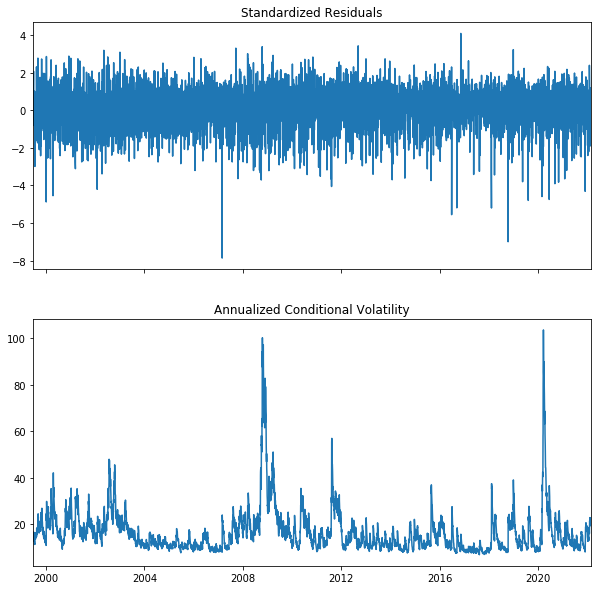

In [133]:
# Example - Univariate Fitting
fig = model_list[0][1].plot(scale=252)
fig.set_size_inches(10, 10)

In [6]:
# Creating the matrix of residuals and scatter plotting
for k, item in enumerate(model_list):
    if k == 0:
        df_log_resid = pd.DataFrame(item[1].std_resid)
        df_log_resid.rename(columns={df_log_resid.columns[-1]:item[0].y.name}, inplace=True)
    else:
        df_log_resid = pd.concat([df_log_resid, pd.DataFrame(item[1].std_resid)], axis=1)
        df_log_resid.rename(columns={df_log_resid.columns[-1]:item[0].y.name}, inplace=True)

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


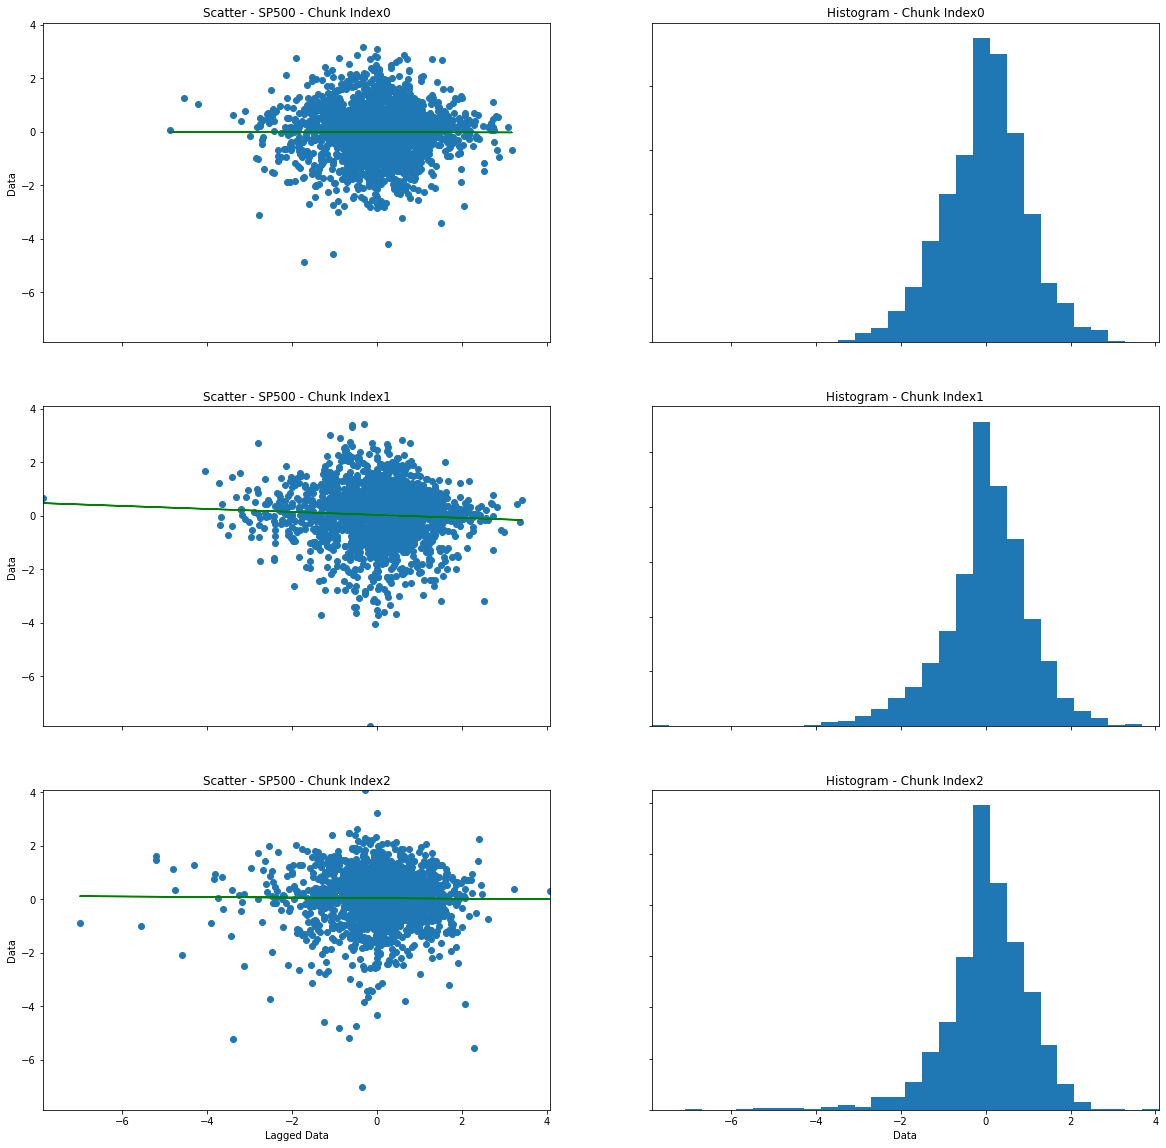

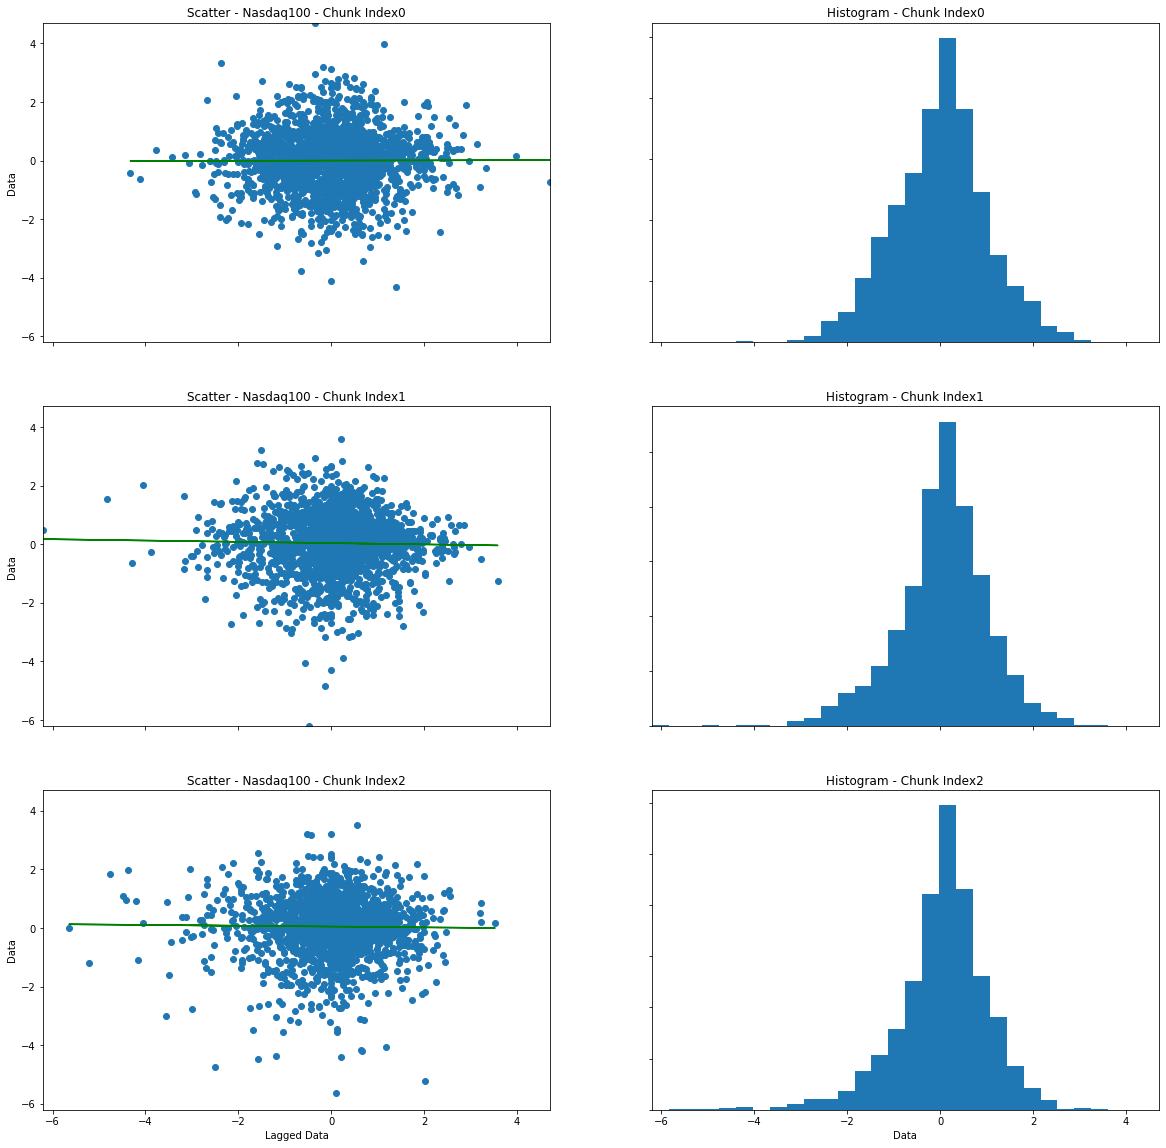

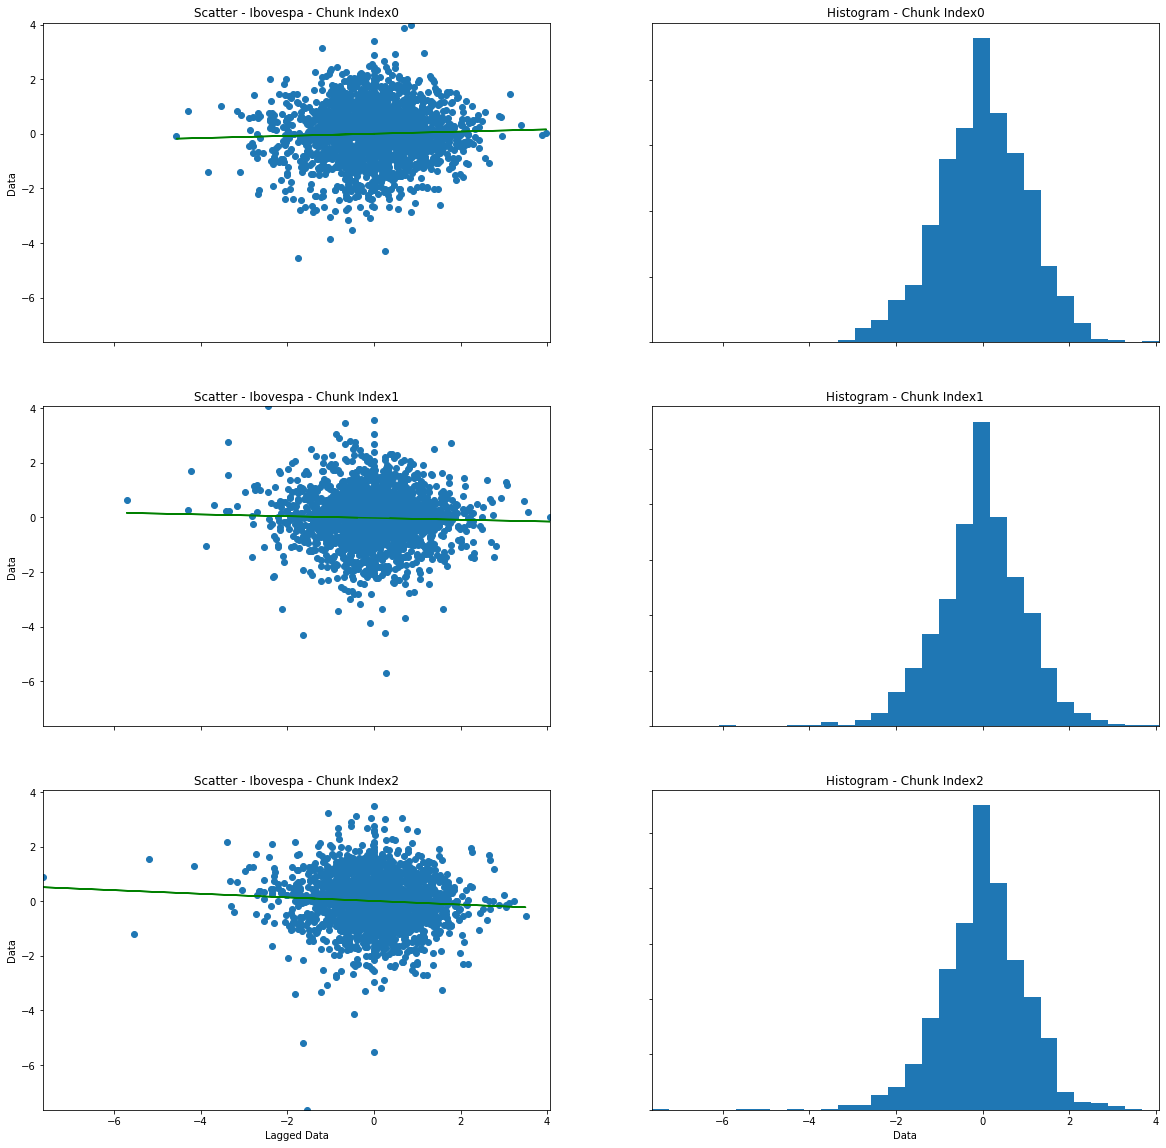

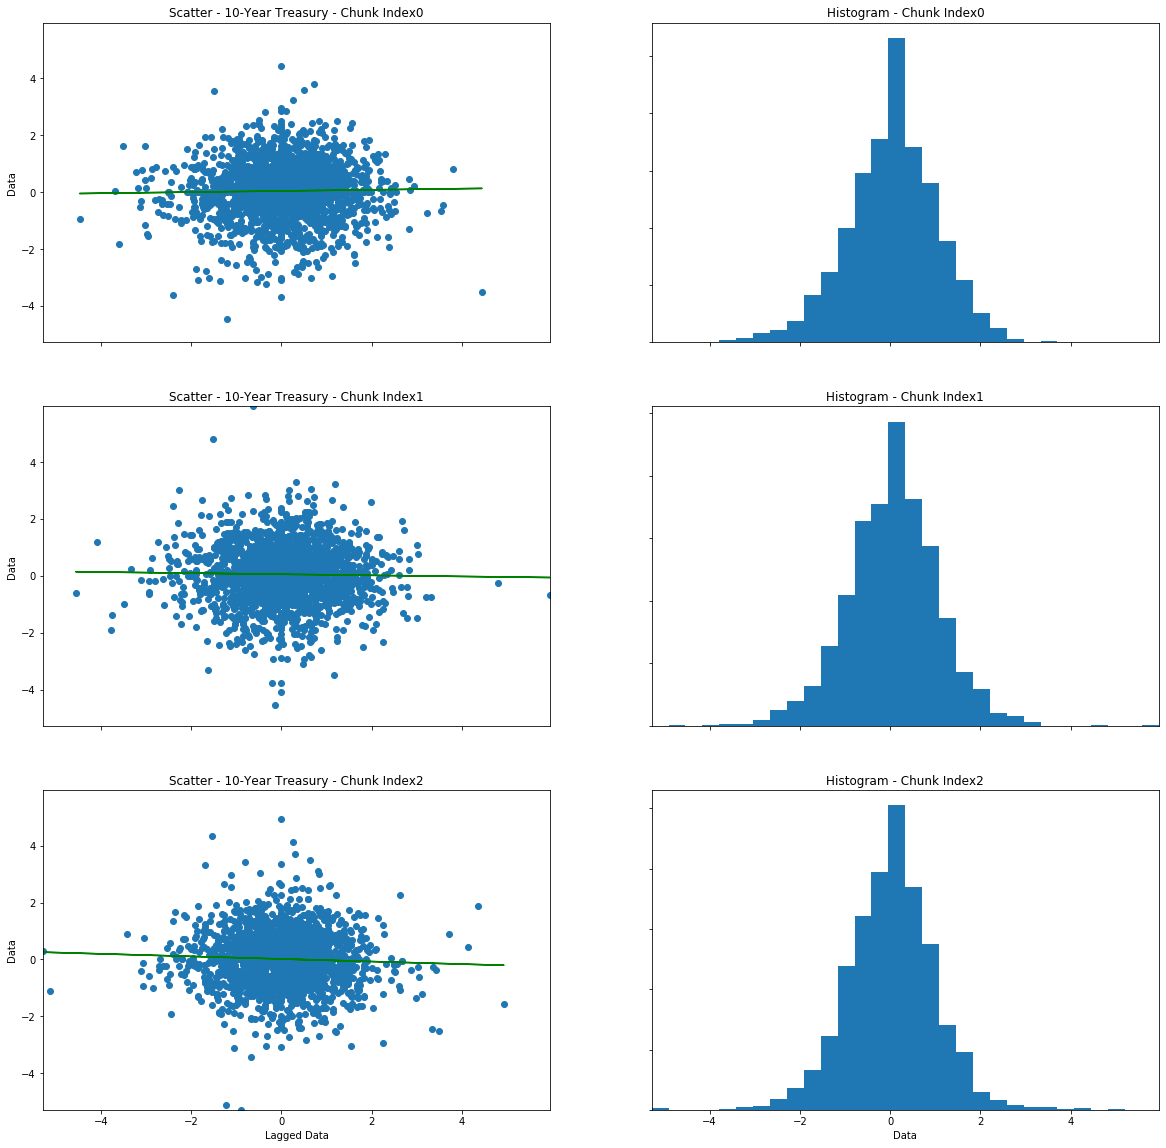

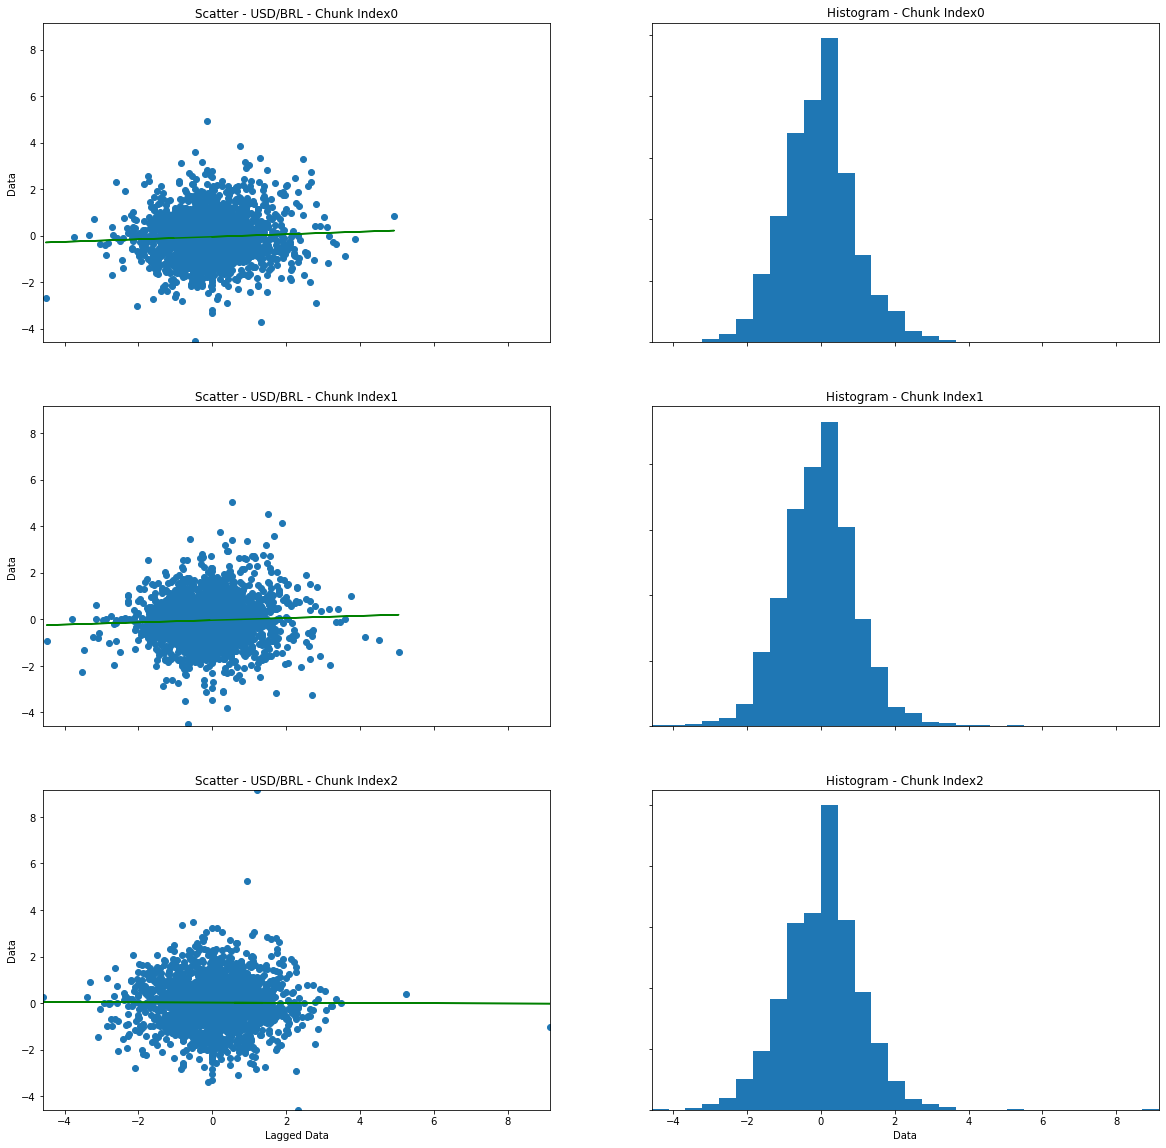

In [7]:
# Quick Invariance Analysis - Of residuals
for item in df_log_resid.columns:
    fig, axs = quick_invariance_analysis(df_log_resid[item], n_chunks=3, nbins=30)
    fig.set_size_inches(20, 20)

In [8]:
# Calculating the pseudo-observations - Estimated Probability Integral Transform
for k, item in enumerate(model_list):
    if k == 0:
        df_log_resid_pseudo_observations = pd.DataFrame(sci.stats.norm.cdf(df_log_resid.iloc[:, k]))
    else:
        df_log_resid_pseudo_observations = pd.concat([df_log_resid_pseudo_observations, pd.Series(sci.stats.norm.cdf(df_log_resid.iloc[:, k]))], axis=1, ignore_index=True)

df_log_resid_pseudo_observations.columns = df_log_resid.columns
df_log_resid_pseudo_observations.columns = df_log_resid.columns
df_log_resid_pseudo_observations.index=df_log_resid.index

In [9]:
# Empirical Copula Plotting
fig1 =  px.scatter_matrix(data_frame=df_log_resid_pseudo_observations,
                          dimensions=df_log_resid_pseudo_observations.columns,
                          height=2000, width=2000)
fig1.update_traces(marker=dict(size=4, line=dict(width=1)), opacity=0.6, showlegend=False)
#fig1.update_traces(diagonal_visible=False)
fig1.update_layout(plot_bgcolor = "#ffebe3", colorway = ["#ff774a"], title = "Empirical Copula")
fig1.update_layout({"yaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig1.update_layout({"xaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig1.update_xaxes(visible=True, showgrid=True)
fig1.update_yaxes(visible=True, showgrid=True)
fig1.write_html("HTML/file.html")
fig1.show()

In [10]:
# Meta Distribution - Distribution which is constructed by an arbitrary copula and arbitrary marginal distributions

In [11]:
# Creating Vine - Structure
copVine = pv.Vinecop(d = df_log_resid_pseudo_observations.columns.shape[0])

# Selecting Most Appropriate Model Given pseudo-observations
copVine.select(data=df_log_resid_pseudo_observations)

In [12]:
print(copVine.str())

** Tree: 0
2,1 <-> Student, parameters = 0.893757
 9.51156
4,1 <-> Student, parameters = -0.295124
  8.62378
1,3 <-> Student, parameters = 0.534157
 13.3647
3,5 <-> Student, parameters = -0.492078
  12.5336
** Tree: 1
2,3 | 1 <-> Student, parameters = 0.0258263
  18.9007
4,3 | 1 <-> Student, parameters = -0.0275507
   39.1932
1,5 | 3 <-> Student, parameters = -0.0794997
   32.1504
** Tree: 2
2,5 | 3,1 <-> Frank, parameters = 0.241336
4,5 | 3,1 <-> Student, parameters = -0.0499529
   39.0712
** Tree: 3
2,4 | 5,3,1 <-> Student, parameters = 0.0160907
  27.4015



In [13]:
print(f"AIC: {copVine.aic()}")
print(f"BIC: {copVine.bic()}")
print(f"loglik: {copVine.loglik()}")
print(f"Modified Bayesian Information Criteria: {copVine.mbicv()}")

AIC: -13766.312873900208
BIC: -inf
loglik: 6902.156436950104
Modified Bayesian Information Criteria: -inf


In [14]:
# Simulating U - Given Vine - Empirical X Simulated Copulas
n_sim = 10000
u_sim = pd.DataFrame(copVine.simulate(n_sim, seeds=seeds), columns=df_log_resid_pseudo_observations.columns)

In [15]:
# Plotting simulation results given Vine
fig2 =  px.scatter_matrix(data_frame=u_sim,
                          dimensions=u_sim.columns,
                          height=2000, width=2000)
fig2.update_traces(marker=dict(size=4, line=dict(width=1)), opacity=0.6, showlegend=False)
fig2.update_layout(plot_bgcolor = "#ffebe3", colorway = ["#ff774a"], title = "Simulated Data - Given Vine Structure")
fig2.update_layout({"yaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig2.update_layout({"xaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig2.update_xaxes(visible=True, showgrid=True)
fig2.update_yaxes(visible=True, showgrid=True)
fig2.write_html("HTML/simulated.html")
fig2.show()

In [16]:
# Scenario Simulation - Vine Copula
scenarios_copula = list()

for k in range(n_scenarios):
    scenario_copula = dict()
    scenario_copula['u_sim'] = pd.DataFrame(copVine.simulate(n_os), columns=df_log_resid_pseudo_observations.columns)

    sim_given_models_copula = []
    for d, model in enumerate(model_list):
        # Filterting data - Given Models + Simulated Residuals
        sim_given_models_copula.append(zero_mean_garch_1_1_scenario(sci.stats.norm.ppf(scenario_copula['u_sim'].iloc[:, d]), model[1].conditional_volatility,
                                                             model[1].resid, w=model[1].params.omega, alpha=model[1].params['alpha[1]'],
                                                             beta=model[1].params['beta[1]']))
        # Return projection for the proposed horizon
        if d == 0:
            projected_returns_simulation_copula = pd.DataFrame(pd.Series(np.exp(np.cumsum(sim_given_models_copula[d][0] / returns_scale_factor)) - 1))
        else:
            projected_returns_simulation_copula = pd.concat([projected_returns_simulation_copula, pd.Series(np.exp(np.cumsum(sim_given_models_copula[d][0] / returns_scale_factor)) - 1)], axis=1, ignore_index=True)

    projected_returns_simulation_copula.index = df_log_ret.index[-n_os:]
    projected_returns_simulation_copula.columns = selected_securities

    scenario_copula["sim_given_models"] = sim_given_models_copula
    scenario_copula["projections"] = projected_returns_simulation_copula

    scenarios_copula.append(scenario_copula)

# Scenarios Projections
scenario_projections_copula = np.zeros((n_scenarios, len(selected_securities)))

for k, scenario in enumerate(scenarios_copula):
    scenario_projections_copula[k, :] = scenario["projections"].iloc[-1, :].to_numpy()

scenario_projections_copula = pd.DataFrame(scenario_projections_copula, columns = selected_securities)

In [17]:
# Ledoit and Wolf - Shrinked Gaussian Covariance Estimate
from sklearn.model_selection import GridSearchCV
from sklearn.covariance import LedoitWolf
from sklearn.covariance import ShrunkCovariance

n_split = np.floor(df_log_resid.shape[0] / 2).astype(int)
X_train = df_log_resid.iloc[0:n_split, :]
X_test = df_log_resid.iloc[n_split:, :]

shrinkages = np.logspace(-2, 0, 30)

# GridSearch for an optimal shrinkage coefficient
tuned_parameters = [{"shrinkage": shrinkages}]
cv = GridSearchCV(ShrunkCovariance(), tuned_parameters)
cv.fit(X_train)

# Ledoit-Wolf optimal shrinkage coefficient estimate
lw = LedoitWolf()
lw_fit = lw.fit(X_train)

In [18]:
# Scenario Simulation - Ledoit and Wolf
scenarios_ld = list()

for k in range(n_scenarios):
    scenario_ld = dict()
    scenario_ld['std_resid_sim'] = pd.DataFrame(np.random.multivariate_normal(mean=np.zeros(shape=(len(selected_securities))), cov=lw_fit.covariance_, size=n_os), columns=selected_securities)

    sim_given_models_ld = []
    for d, model in enumerate(model_list):
        # Filterting data - Given Models + Simulated Residuals
        sim_given_models_ld.append(zero_mean_garch_1_1_scenario(scenario_ld['std_resid_sim'].iloc[:, d].to_numpy(), model[1].conditional_volatility,
                                                             model[1].resid, w=model[1].params.omega, alpha=model[1].params['alpha[1]'],
                                                             beta=model[1].params['beta[1]']))
        # Return projection for the proposed horizon
        if d == 0:
            projected_returns_simulation_ld = pd.DataFrame(pd.Series(np.exp(np.cumsum(sim_given_models_ld[d][0] / returns_scale_factor)) - 1))
        else:
            projected_returns_simulation_ld = pd.concat([projected_returns_simulation_ld, pd.Series(np.exp(np.cumsum(sim_given_models_ld[d][0] / returns_scale_factor)) - 1)], axis=1, ignore_index=True)

    projected_returns_simulation_ld.index = df_log_ret.index[-n_os:]
    projected_returns_simulation_ld.columns = selected_securities

    scenario_ld["sim_given_models"] = sim_given_models_ld
    scenario_ld["projections"] = projected_returns_simulation_ld

    scenarios_ld.append(scenario_ld)

# Scenarios Projections
scenario_projections_ld = np.zeros((n_scenarios, len(selected_securities)))

for k, scenario in enumerate(scenarios_ld):
    scenario_projections_ld[k, :] = scenario["projections"].iloc[-1, :].to_numpy()

scenario_projections_ld = pd.DataFrame(scenario_projections_ld, columns = selected_securities)

In [19]:
# Volatilities - Vine Copula
print(scenario_projections_copula.std())

# Correlation - Vine Copula
print(scenario_projections_copula.corr())

SP500               0.197637
Nasdaq100           0.307122
Ibovespa            0.271930
10-Year Treasury    0.054834
USD/BRL             0.194619
dtype: float64
                     SP500  Nasdaq100  Ibovespa  10-Year Treasury   USD/BRL
SP500             1.000000   0.852276  0.484186         -0.276539 -0.241680
Nasdaq100         0.852276   1.000000  0.424273         -0.224260 -0.203873
Ibovespa          0.484186   0.424273  1.000000         -0.156884 -0.392972
10-Year Treasury -0.276539  -0.224260 -0.156884          1.000000  0.061265
USD/BRL          -0.241680  -0.203873 -0.392972          0.061265  1.000000


In [20]:
# Volatilities - Ledoit and Wolf
print(scenario_projections_ld.std())

# Correlation Ledoit and Wolf
print(scenario_projections_ld.corr())

SP500               0.279935
Nasdaq100           0.729910
Ibovespa            0.307895
10-Year Treasury    0.060619
USD/BRL             0.155552
dtype: float64
                     SP500  Nasdaq100  Ibovespa  10-Year Treasury   USD/BRL
SP500             1.000000   0.451775  0.401945         -0.157788 -0.217669
Nasdaq100         0.451775   1.000000  0.243455         -0.086880 -0.110698
Ibovespa          0.401945   0.243455  1.000000         -0.114683 -0.451085
10-Year Treasury -0.157788  -0.086880 -0.114683          1.000000  0.076668
USD/BRL          -0.217669  -0.110698 -0.451085          0.076668  1.000000


# Target Risk Budget

Introduction to Risk Parity and Budgeting - Thierry Roncalli
See http://www.thierry-roncalli.com/RiskParityBook.html


#### Idea: a target in terms of risk contribution to each security in a portfolio

A Risk measure $\mathcal{R}$ is said coherent Artznet et al(1999) if it satisfies the following properties:
- Subadditivity(Risk of 2 portfolios smaller compared to the risk of two separate portfolios): $\mathcal{R} \left(\lambda x\right) = \lambda\mathcal{R}\left(x\right)$
- Homogeneity: $\mathcal{R}\left(x_1 + x_2\right) \leq \mathcal{R}\left(x_1\right) \mathcal{R}\left(x_2\right) $
- Monotonicity(Order relation): $x_1 < x_2$, then $\mathcal{R}\left(x_1\right) > \mathcal{R}\left(x_2\right)$
- Translation Invariance(Add cash amount reduce risk): if $m \in \mathbb{R}$, then $\mathcal{R}\left(x + m\right) = \mathcal{R}\left(x\right) - m$


Follmer and Shied (2002) - Proposed to substitute Subadditivity and Homogeneity by a weaker condtion (diversification should not increase risk):
- Convexity Property: $\mathcal{R} \left(\lambda x_1 + \left(1-\lambda\right) x_2 \right) \leq \lambda\mathcal{R}\left(x_1\right) + \left(1 - \lambda\right)\mathcal{R}\left(x_1\right)$


By defining the loss as

\begin{align}
    \mathcal{L}\left(x\right) = -\mathcal{R}\left(x\right)
\end{align}

The idea of this problem is to set the targeted risk contribution depending on the risk measure selected through the "Euler Allocation Principle"


\begin{align}
    \mathcal{R}\left(x\right) = x'\nabla \mathcal{R\left(x\right)}
\end{align}

A risk measure $\mathcal{R}$ satisfying the properties listed above satisfies the principle(see Roncalli). For example, one can choose the volatility of the portfolio as a risk measure and target the contribution of each asset class in the aggregate portfolio.

\begin{align}
    \mathcal{R}\left(x\right) = \sqrt{x' \Sigma x}
\end{align}

Then, each component of a portfolio could contribute marginally to the whole through the following sensitivities

\begin{align}
 \frac{\partial \mathcal{R}\left(x\right)}{\partial x} = \frac{x'\Sigma}{\left(x'\Sigma x\right)^{\frac{1}{2}}}
\end{align}

Since the scenario modelling implemented in this work have adverse events and other multivariate characteristics being treated, an exercise constraining for the V@R will be implemented for analysis purposes

\begin{align}
    \mathcal{R}\left(x\right) = VaR_{\alpha}\left(x\right) = inf\{l: \mathbb{P}\{\mathcal{L}\left(x\right) \leq l\} \geq \alpha\}
\end{align}

### Optimization Problem

The Risk Budgeting portfolio will have as solution the one of the following non-linear problem

\begin{align}
    x^* = \{x \in \left[0, 1\right]^n : \sum_{i=1}^{n}x_i = 1, \partial_{x_i} \mathcal{R}\left(x\right) = b_i\mathcal{R}\left(x\right), b \in \left]0,1\right]^n, \sum_{i=1}^{n}b_i=1 \}
\end{align}

Better approach: Transform into an optmization problem like

\begin{align}
    x^* = argmin f\left(x;b\right)\\
    u.c \text{ } \mathbb{1}'x = 1, \mathbb{0} \leq x \leq \mathbb{1}
\end{align}

As an example, $f$ could be specified as


\begin{align}
    f\left(x;b\right) = \sum_{i=1}^{n}\left(x_i \partial \mathcal{R}\left(x\right) - b_i \mathcal{R}\left(x\right)\right)
\end{align}


Which can be solved by the Sequential Quadratic Programing Algorithm.

<Figure size 2160x864 with 0 Axes>

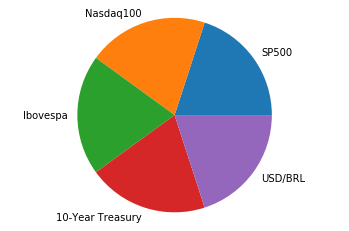

In [21]:
b = np.ones(len(selected_securities))/ np.sum(np.ones(len(selected_securities)))

plt.figure(figsize=(30,12))
fig1, ax1 = plt.subplots()
ax1.pie(b, labels = selected_securities)
ax1.axis('equal')
plt.show()

In [47]:
# Allocation example
# Settings
from RiskBudgeting import RiskBudgeting, plot_pnl_evolution, compute_pnl_evolution
from scipy import optimize
from scipy.optimize import NonlinearConstraint

eps = 0.000000000000001
large_number = 10000000
risk_target = 0.25
ann_factor = 252

b = np.ones(len(selected_securities))/ np.sum(np.ones(len(selected_securities)))

# Functions
risk_obj = RiskBudgeting()

sigma2_copula = scenario_projections_copula.cov().to_numpy()
sigma2_ld =  scenario_projections_ld.cov().to_numpy()

# Risk Measure
PRC_copula = lambda w: risk_obj.risk_contribution(w, sigma2_copula) / np.sum(risk_obj.risk_contribution(w, sigma2_copula))
PRC_ld = lambda w: risk_obj.risk_contribution(w, sigma2_ld) / np.sum(risk_obj.risk_contribution(w, sigma2_ld))

# Defining problem initial values, constraints and boundaries
c = b.dot(np.log(b)) - eps

def ineq_constraint(x, b_target, c):
    return np.transpose(b_target).dot(np.log(x)) - c

# w0 = np.ones(b.shape)*1
bounds = [(eps, np.inf)] * b.shape[0]

ineq_const = {'type': 'ineq',
              'fun': lambda x: ineq_constraint(x, b, c),
              'jac': lambda x: b * (1 / x)}

shape_gamma = np.random.uniform(0.01, 5, 1)
scale_gamma = np.random.uniform(0.01, 5, 1)
list_w0 = np.random.gamma(shape=shape_gamma[0], scale=scale_gamma[0], size=b.shape[0])
print(list_w0)

[5.35150893 9.40098204 3.95415212 4.21943664 5.32281149]


In [66]:
# Optimizing - Ledoit and Wolf
res_ld = optimize.minimize(lambda x: risk_obj.risk_measure(x, sigma2_ld),
                               x0=list_w0,
                               method='SLSQP',
                               constraints=ineq_const,
                               bounds=bounds,
                               jac=lambda x: risk_obj.jacobian(x, sigma2_ld),
                               options={'maxiter': 10000000, 'ftol': 1e-18})

print(res_ld)

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\scipy\optimize\_minimize.py:528: RuntimeWarning:

Method SLSQP does not use Hessian information (hess).

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning:

divide by zero encountered in log



     fun: array([0.09729886])
     jac: array([0.14804766, 0.39844296, 0.12321422, 0.02423031, 0.04951664])
 message: 'Positive directional derivative for linesearch'
    nfev: 301
     nit: 216
    njev: 212
  status: 8
 success: False
       x: array([0.13144261, 0.04883954, 0.15793445, 0.80311701, 0.39299455])


In [48]:
# Optimizing - Copula - without VaR restriction
res_copula = optimize.minimize(lambda x: risk_obj.risk_measure(x, sigma2_copula),
                               x0=list_w0,
                               method='SLSQP',
                               constraints=ineq_const,
                               bounds=bounds,
                               jac=lambda x: risk_obj.jacobian(x, sigma2_copula),
                               options={'maxiter': 10000000, 'ftol': 1e-18})

print(res_copula)

     fun: array([0.07810442])
     jac: array([0.11099496, 0.17972546, 0.11955302, 0.01946554, 0.06260918])
 message: 'Optimization terminated successfully'
    nfev: 276
     nit: 174
    njev: 172
  status: 0
 success: True
       x: array([0.14073507, 0.08691525, 0.13066071, 0.80248899, 0.24949829])


C:\Users\yuriv\.conda\envs\py37\lib\site-packages\scipy\optimize\_minimize.py:528: RuntimeWarning:

Method SLSQP does not use Hessian information (hess).

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



In [126]:
# Optimizing - Copula - with V@R Restriction
confidence = 0.95
var_at_confidence = -0.30

def value_at_risk(x, scenarios, confidence, norm_func=None):
    if norm_func is not None:
        factor = norm_func(x)
    else:
        factor = 1

    loss = -1 * np.sum((x * factor) * scenarios, axis=1).sort_values(ascending=True)
    confidence_vector = np.ones(scenarios.shape[0])
    confidence_vector = 1 - np.cumsum(confidence_vector / np.sum(confidence_vector))
    flag = (confidence_vector <= confidence)
    return -loss[flag].values[0]

def fun_con(x):
    return value_at_risk(x, scenario_projections_copula, confidence, norm_func = lambda y: risk_target / risk_obj.risk_measure(y, sigma2_copula)[0]) - var_at_confidence

constrains = [ineq_const, NonlinearConstraint(fun=fun_con, lb=0, ub=np.inf)]

res_copula_w_restriction = optimize.minimize(lambda x: risk_obj.risk_measure(x, sigma2_copula),
                                              x0=list_w0,
                                              method='SLSQP',
                                              constraints=constrains,
                                              bounds=bounds,
                                              jac=lambda x: risk_obj.jacobian(x, sigma2_copula),
                                              options={'maxiter': 10000000, 'ftol': 1e-18})

print(res_copula_w_restriction)

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



     fun: array([0.09883235])
     jac: array([ 0.15199348,  0.23625698,  0.14341588, -0.00229697,  0.05076759])
 message: 'Optimization terminated successfully'
    nfev: 4392
     nit: 1192
    njev: 1188
  status: 0
 success: True
       x: array([0.21814305, 0.12406235, 0.15182584, 0.34994171, 0.30324465])


In [125]:
shape_gamma = np.random.uniform(0.01, 5, 1)
scale_gamma = np.random.uniform(0.01, 10, 1)
list_w0 = np.random.gamma(shape=shape_gamma[0], scale=scale_gamma[0], size=b.shape[0])
#list_w0[:] = 12
list_w0

array([15.59156778, 22.14250112, 16.90006455, 26.61044731, 14.45349375])

In [127]:
# Allocation Weights
factor_copula = risk_target / risk_obj.risk_measure(res_copula.x, sigma2_copula)[0]
factor_copula_w_restriction = risk_target / risk_obj.risk_measure(res_copula_w_restriction.x, sigma2_copula)[0]
factor_ld = risk_target / risk_obj.risk_measure(res_ld.x, sigma2_ld)[0]

print("Allocation Weights\n")
allocation_weights = pd.DataFrame({"VineCopula":res_copula.x * factor_copula,
                                   "VineCopulaV@R":res_copula_w_restriction.x * factor_copula_w_restriction,
                                   "LedoitWolf":res_ld.x * factor_ld}, index=selected_securities)
print(allocation_weights)

Allocation Weights

                  VineCopula  VineCopulaV@R  LedoitWolf
SP500               0.450471       0.551801    0.337729
Nasdaq100           0.278202       0.313820    0.125488
Ibovespa            0.418224       0.384049    0.405797
10-Year Treasury    2.568642       0.885190    2.063532
USD/BRL             0.798605       0.767068    1.009761


Backtests


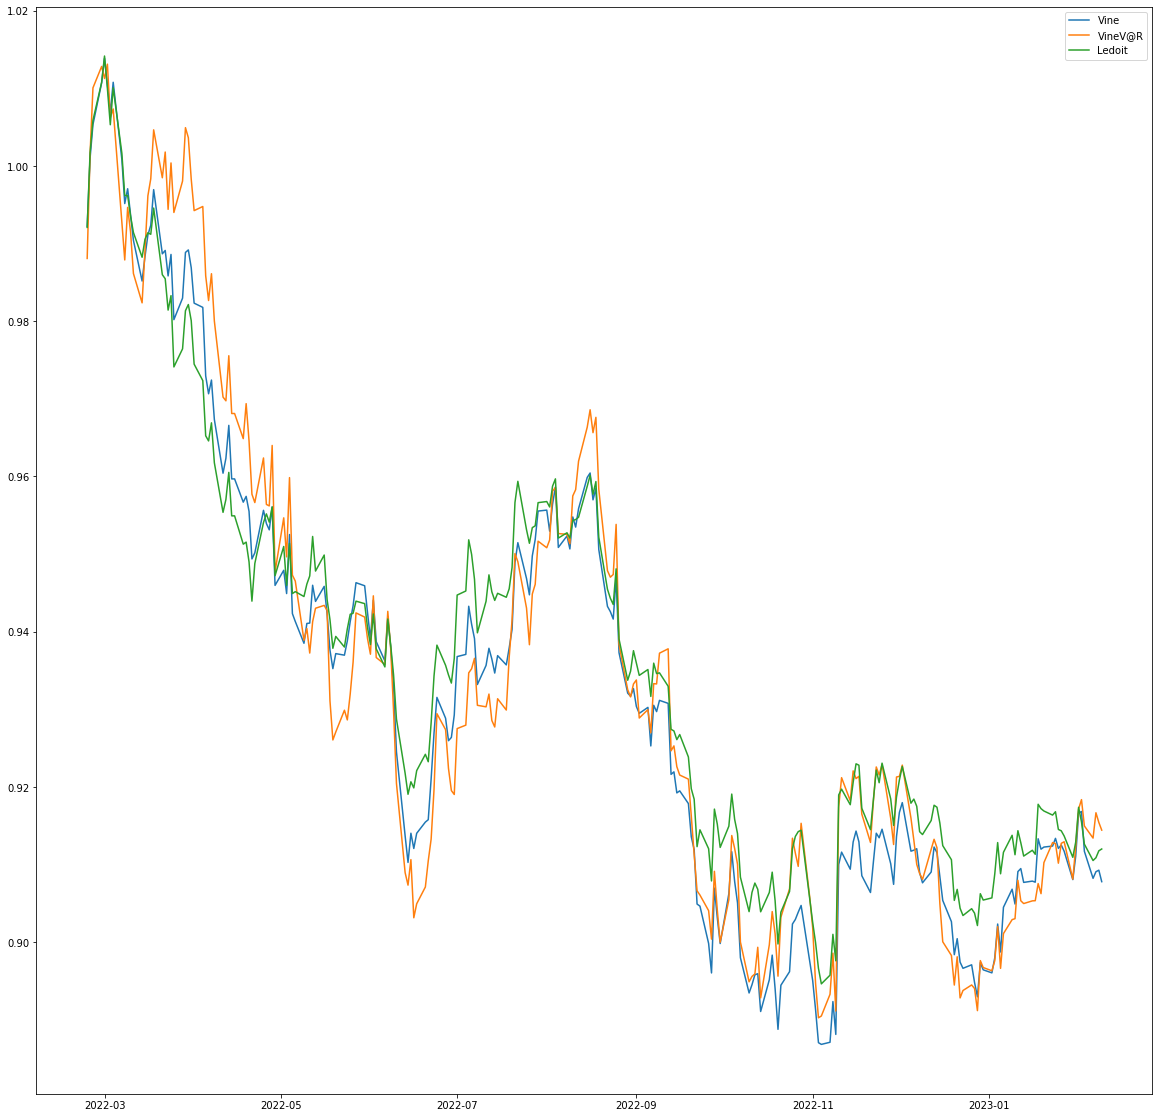

In [128]:
# Plotting Accumulated Returns - Backtest
print("Backtests")
quotes_os = pd.DataFrame({"VineCopula": compute_pnl_evolution(allocation_weights["VineCopula"], df_log_ret.iloc[-n_os:, :] / returns_scale_factor), "VineCopulaV@R": compute_pnl_evolution(allocation_weights["VineCopulaV@R"], df_log_ret.iloc[-n_os:, :]/returns_scale_factor), "Ledoit": compute_pnl_evolution(allocation_weights["LedoitWolf"], df_log_ret.iloc[-n_os:, :]/returns_scale_factor)}, index=df_log_ret.iloc[-n_os:, :].index)

fig, ax = plt.subplots()
ax.plot(quotes_os.iloc[:, 0], label="Vine")
ax.plot(quotes_os.iloc[:, 1], label="VineV@R")
ax.plot(quotes_os.iloc[:, 2], label="Ledoit")
leg = ax.legend()
fig.set_size_inches(20, 20)

In [129]:
# Backtest Realized Volatility - Out of Sample
print(np.log(quotes_os).diff().std() * np.sqrt(252))

VineCopula       0.071622
VineCopulaV@R    0.090865
Ledoit           0.064978
dtype: float64


(-1, 2)

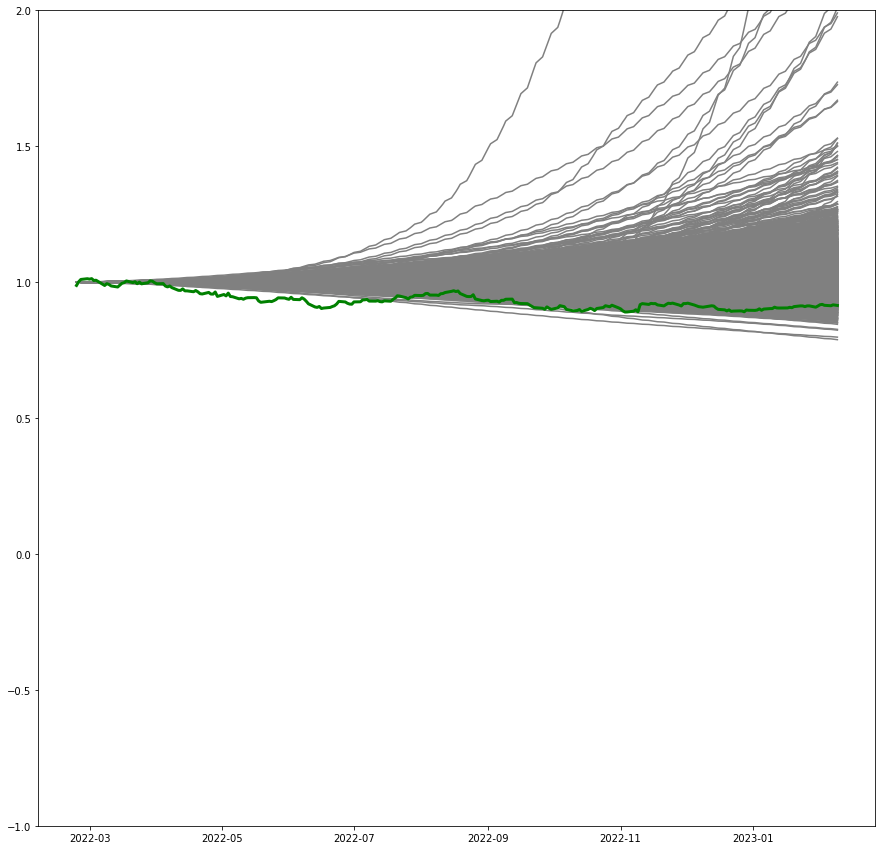

In [130]:
# Plotting P&L Copula Scenarios - Together with the Backtest
fig, ax = plot_pnl_evolution(allocation_weights["VineCopula"], [item['projections']/returns_scale_factor for item in scenarios_copula], set_size_inches = [15, 15])
ax.set_ylim(-1, 2)

ax.plot(quotes_os.iloc[:, 1], color="green", linewidth=3)
ax.set_ylim(-1, 2)

(-1, 2)

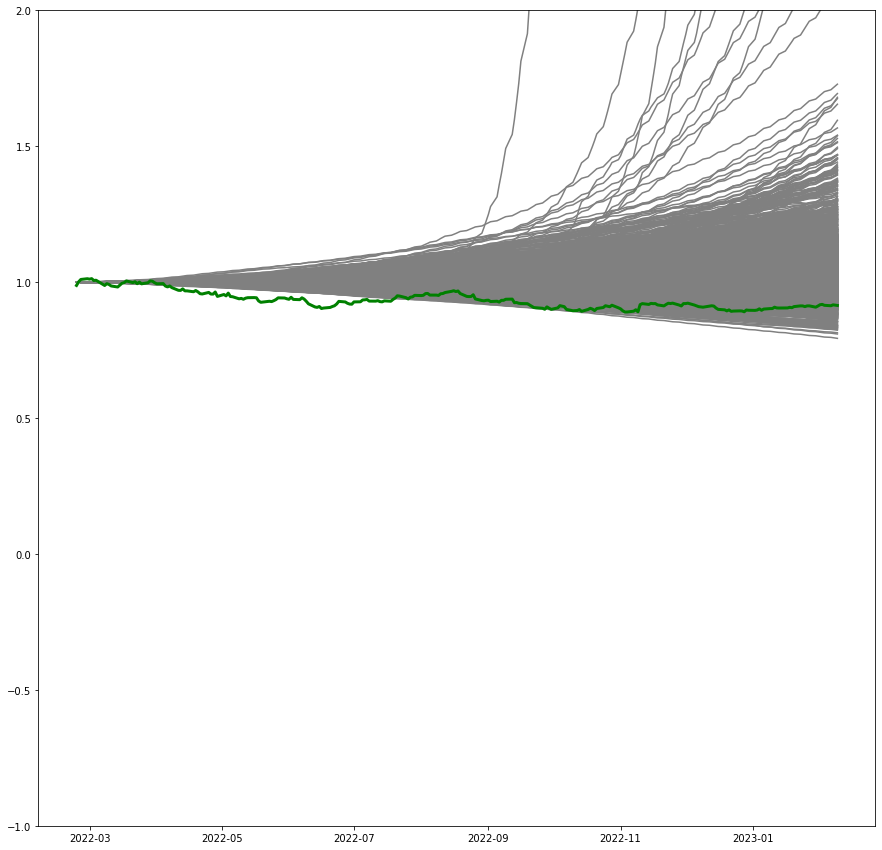

In [131]:
# Plotting P&L Ledoit and Wolf Scenarios - Together with the Backtest
fig, ax = plot_pnl_evolution(allocation_weights["VineCopula"], [item['projections']/returns_scale_factor for item in scenarios_ld], set_size_inches = [15, 15])
ax.set_ylim(-1, 2)

ax.plot(quotes_os.iloc[:, 1], color="green", linewidth=3)
ax.set_ylim(-1, 2)